![Twitter Sentiment Analysis](tt.png)

# Sentiment Analysis From Scratch: A Deep Dive into Twitter Data

### Notebook 3: Neural Network Modeling

In this notebook, the focus is on the construction, training, and evaluation of neural networks for sentiment classification. Vectorization methods trained in the previous notebook are used to prepare the data. Various neural network architectures and hyperparameters are systematically tested to identify the most effective combination for sentiment analysis. To ensure transparency and reproducibility, MLflow is employed as a central tracking tool, capturing details, metrics, and outcomes of each model iteration.

***

### Importing Libraries and Dependencies

In [1]:
# Standard libraries for file and time operations
import os
import time

# Library for regular expressions
import re

# Libraries for random number generation and suppressing warnings
import random
import warnings

# Libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd
from itertools import product

# Library for experiment tracking
import mlflow

# Libraries for model evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Library for data splitting
from sklearn.model_selection import train_test_split

# Libraries for text tokenization
from nltk import tokenize
from nltk.tokenize import WhitespaceTokenizer

# Library for Word2Vec model
from gensim.models import Word2Vec

# Libraries for deep learning with PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import GRU

# Libraries for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Library for clearing Jupyter Notebook cell output
from IPython.display import clear_output

# Libraries for statistical tests
import scipy.stats as stats
from scipy import stats
from scipy.stats import mannwhitneyu,kruskal,shapiro,levene, bartlett

# Inline plotting for Jupyter Notebook
%matplotlib inline

# Suppress warnings
warnings.simplefilter(action='ignore', category=Warning)

### Setting seeds for reproducibility

In the field of data science and machine learning, it is paramount to ensure the reproducibility of experiments. This is achieved by setting a seed value for random number generation, which helps to maintain the consistency of the results across multiple runs. This procedure establishes deterministic behavior for operations that would otherwise be random, facilitating the precise replication of results by other researchers or by themselves at a later date.

However, it is vital to note that, despite having set seed values to ensure reproducibility, some functions and operations within PyTorch may still operate in a non-deterministic manner. This means that, even when recreating the environment and the conditions of the experiment, small variations in the results can be observed with each new run. 


In [2]:
def set_seed(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
set_seed(5)

### Loading Dataset cleaned

In [3]:
tweets = pd.read_csv('training.1600000.processed.noemoticon_cleaned.csv')
tweets.head(3)

,target,text,text2,text3,text4,text5,text6
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - awww, that's bummer. shoulda got...",switchfoot awww bummer shoulda got david carr ...,switchfoot awww bummer shoulda got david carr ...,switchfoot awww bummer shoulda got david carr ...,switchfoot awww bummer shoulda got david carr ...
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting it... migh...,upset update facebook texting ... might cry re...,upset update facebook texting ... might cry re...,upset updat facebook text ... might cri result...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,@kenichan dived many times ball. managed save ...,kenichan dived many times ball managed save 50...,kenichan dived many times ball managed save 50...,kenichan dive mani time ball manag save 50 res...,kenichan dive mani time ball manag save rest g...


### Splitting Data into Training and Testing Sets

To robustly evaluate model performance, the data is split into training and testing sets. The training set is used to train the model, while the testing set is reserved to assess the model's performance on previously unseen data.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(tweets['text6'], tweets['target'], random_state = 5, train_size=0.8)

### Data Vectorization

In this step, the previously trained Word2Vec models (CBOW and Skip-Gram) are used to convert the tweet text into numerical vectors. This vectorization is essential for preparing the data for neural network training. Each tweet is transformed into a dense numerical representation, which serves as input for the sentiment classification model.

In [5]:
# Define the paths to the pre-trained Word2Vec models (CBOW and SG)
cbow_path = 'models/word2vec_cbow.model'
sg_path = 'models/word2vec_sg.model'

# Load the pre-trained models from the specified paths
cbow = Word2Vec.load(cbow_path)
sg = Word2Vec.load(sg_path)

In [6]:
# Initializes the whitespace tokenizer from the nltk library
ws_tokenizer = tokenize.WhitespaceTokenizer()

# Defines a function to convert text into numerical vectors using a given Word2Vec model
def vectorize (text, modelo):
    # Gets the number of text samples and sets the vector dimension (300 in this case)
    x = len(text)
    y = 300

    # Initializes a zero matrix of shape (x, y)
    matrix = np.zeros((x,y))

    # Iterates through each text sample in the input DataFrame
    for i in range(x):
        # Tokenizes the text sample into words using whitespace as the delimiter
        words = ws_tokenizer.tokenize(text.iloc[i])

        # Iterates through each word in the tokenized text
        for word in words:
            # Checks if the word exists in the Word2Vec model's vocabulary
            if word in modelo.wv:
                # Adds the word vector to the corresponding row in the matrix
                matrix[i] += modelo.wv.get_vector(word)
    return matrix

In [7]:
# Records the time at which the vectorization process starts
start_time = time.time()

# Vectorizes training and test data using CBOW model
matrix_train_cbow = vectorize(X_train, cbow)
matrix_test_cbow = vectorize(X_test, cbow)

# End timer and print elapsed time
end_time = time.time()
duration = end_time - start_time
print('Data Vectorized. Elapsed Time: {:.2f} seconds.'.format(duration))

Data Vectorized. Elapsed Time: 61.51 seconds.


In [8]:
# Records the time at which the vectorization process starts
start_time = time.time()

# Vectorizes training and test data using SG model
matrix_train_sg= vectorize(X_train, sg)
matrix_test_sg = vectorize(X_test, sg)

# End timer and print elapsed time
end_time = time.time()
duration = end_time - start_time
print('Data Vectorized. Elapsed Time: {:.2f} seconds.'.format(duration))

Data Vectorized. Elapsed Time: 61.04 seconds.


### Setting Up the Computational Device
In deep learning, especially when dealing with large datasets, utilizing a GPU can significantly accelerate the training process. Before proceeding with training the neural network, it is checked whether a GPU is available. If so, the device is set to use the GPU; otherwise, it defaults to the CPU. The selected device will be used in subsequent computations and model training. By displaying the chosen device, one can confirm the computational resource that will be utilized.

In [9]:
# Choose GPU if available, otherwise use CPU and print the device being used
if torch.cuda.is_available():
    device = torch.device("cuda")          # Use GPU
else:
    device = torch.device("cpu")           # Use CPU

print(f"Device being used: {device}")

Device being used: cuda


## First Experiment: A basic neural network

In the initial experiment, the focus is on training a basic neural network to serve as a foundational model for sentiment analysis. This approach provides a benchmark for more complex architectures and helps to establish a baseline understanding of the dataset's characteristics.

### Setting up the Neural Network Architecture

In this section, the neural network architecture is defined, and functions for training and testing the model are implemented. The `classifier` class sets up the network layers, while the `train` and `test` functions manage the training and evaluation process. Additionally, `MLflow` is utilized to facilitate the tracking and analysis of the experiments.

In [10]:
# Define neural network classifier
class classifier (nn.Module) :
    def __init__(self, input_size, hidden_size, out_size):
        super(classifier, self).__init__()

        # Define hidden layer with ReLU activation
        self.features = nn.Sequential(nn.Linear(input_size,hidden_size),
                                      nn.ReLU()
                                     )
        # Define output layer
        self.out = nn.Linear(hidden_size, out_size)

    # Define forward pass
    def forward(self, X):
        feature = self.features(X)
        output = self.out(feature)
        
        return output

In [11]:
# Training function for a single epoch
def train(train_loader, net, epoch, criterion ,optimizer):
    # Set the network to training mode
    net.train()

    # Initialize list to store batch losses
    epoch_loss = []

    # Iterate through each batch in the training data loader
    for batch in train_loader:
        dado,rotulo = batch
        
        # Move data and labels to the chosen device (CPU or GPU)
        dado,rotulo = dado.to(device), rotulo.to(device)
        
        # Forward pass: compute predictions and loss
        pred = net(dado)
        loss = criterion (pred.squeeze(), rotulo.float())
        epoch_loss.append(loss.cpu().data)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Convert epoch loss to NumPy array and compute mean
    epoch_loss = np.asarray(epoch_loss)
    
    return epoch_loss.mean()

In [12]:
# Testing function for a single epoch
def test(test_loader, net, epoch, criterion):
    # Set the network to evaluation mode
    net.eval()

    # Disable gradient calculations for performance
    with torch.no_grad():
        # Initialize variable for loss
        epoch_loss = []
        
        # Iterate through each batch in the test data loader
        for batch in test_loader:
            dado,rotulo = batch

            # Move data and labels to the chosen device (CPU or GPU)
            dado,rotulo = dado.to(device), rotulo.to(device)

             # Forward pass: compute predictions and loss
            pred = net(dado)
            
            loss = criterion(pred.squeeze(), rotulo.float())
            epoch_loss.append(loss.cpu().data)

        # Convert epoch loss to NumPy array and compute mean
        epoch_loss = np.asarray(epoch_loss)
        
        return epoch_loss.mean()

In [13]:
# Main function to train the neural network
def train_nn(matrix_train, matrix_test, args, hidden_size = 32, input_size = 300, output_size = 1):
    # Start MLflow run for experiment tracking
    with mlflow.start_run(experiment_id=experiment_id):
        # Log hyperparameters
        for key, value in args.items():
            mlflow.log_param(key, value)

        # Log neural network architecture details
        mlflow.log_param('input_size', input_size)
        mlflow.log_param('hidden_size', hidden_size)
        mlflow.log_param('output_size', output_size)

        # Converts training and testing matrices to PyTorch tensors
        X_train = torch.from_numpy(matrix_train).float()
        Y_train = torch.from_numpy(y_train.values)
        train_data = TensorDataset(X_train, Y_train)

        X_test = torch.from_numpy(matrix_test).float()
        Y_test = torch.from_numpy(y_test.values)
        test_data = TensorDataset(X_test, Y_test)

        # Creates data loaders for training and testing datasets
        train_loader = DataLoader(train_data,
                             batch_size=args['batch_size'],
                             shuffle=True,
                             num_workers=args['num_workers'])

        test_loader = DataLoader(test_data,
                                 batch_size=args['batch_size'],
                                 shuffle=True,
                                 num_workers=args['num_workers'])

        # Initializes the neural network classifier
        net = classifier(input_size,hidden_size,output_size)
        net.to(device)

        # Defines the loss function
        criterion = nn.BCEWithLogitsLoss().to(device)
        
        # Chooses the optimizer based on user input
        if args['optimizer'] == 'SGD':
            optimizer = optim.SGD(net.parameters(), lr=args['lr'])
        
        if args['optimizer'] == 'Adam':
            optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

        # Initializes variables to keep track of losses and other metrics
        train_losses, test_losses = [], []
        best_test_loss = float('inf')
        best_model_epoch = -1
        no_improvement_epochs = 0

        # Records the time at which training starts
        start_time = time.time()

        # Main training loop
        for epoch in range(args['num_epochs']):
            # Clears the output and prints the current training status
            clear_output(wait=True)
            
            print('Training neural network... Epoch ' + str(epoch) + '/' + str(args['num_epochs']-1))
            if best_model_epoch!=-1:
                print("Best test loss epoch: " + str(best_model_epoch))

            # Trains the network and logs the loss
            epoch_train_loss = train(train_loader, net, epoch,criterion, optimizer)
            train_losses.append(epoch_train_loss)
            mlflow.log_metric("epoch_train_loss", epoch_train_loss, step=epoch)

            # Tests the network and logs the loss
            epoch_test_loss = test(test_loader, net, epoch, criterion)
            test_losses.append(epoch_test_loss)
            mlflow.log_metric("epoch_test_loss", epoch_test_loss, step=epoch)

            # Checks for improvements in test loss
            dif = best_test_loss - epoch_test_loss
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                # Save the state of the best model for future reference
                torch.save(net.state_dict(), 'backup_best_model.pth')
                mlflow.log_metric("best_test_loss_so_far", best_test_loss, step=epoch)
                best_model_epoch = epoch
            
            # Implements early stopping based on a predefined tolerance and patience
            if dif > args['tolerance']:
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
            if no_improvement_epochs >= args['patience']:
                print("Early stopping at epoch: ", epoch)
                break

        # Records the time at which training ends and calculates the duration
        end_time = time.time()
        duration = end_time - start_time

        # Clears the output and prints the final training status
        clear_output(wait=True)
        print("Neural network training has finished. Elapsed Time: {:.2f} seconds.".format(duration))
        print("Best model saved.")
        print("Best test loss epoch: " + str(best_model_epoch))

        # Loads the best model
        true_test_labels, predicted_test_labels = [], []
        net.load_state_dict(torch.load("backup_best_model.pth"))

        # Uses the best model to make predictions on the test data
        with torch.no_grad():
            for batch in test_loader:
                dado, rotulo = batch
                dado, rotulo = dado.to(device), rotulo.to(device)
                pred = net(dado)
                true_test_labels.extend(rotulo.cpu().numpy())
                predicted_test_labels.extend((torch.sigmoid(pred).squeeze() > 0.5).cpu().numpy()) 
                
        # Calculates performance metrics and logs them using MLflow
        test_accuracy = accuracy_score(true_test_labels, predicted_test_labels)
        test_precision = precision_score(true_test_labels, predicted_test_labels)
        test_recall = recall_score(true_test_labels, predicted_test_labels)
        test_f1 = f1_score(true_test_labels, predicted_test_labels)
        mlflow.pytorch.log_model(net, "models")
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("duration", duration)

        # Prints the performance metrics of the best model
        print("Best model metrics:")
        print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
            test_accuracy, test_precision, test_recall, test_f1))
    
    return(train_losses, test_losses, best_model_epoch)

### Setting Up MLflow Experiment Tracking
This section initializes the experiment tracking using MLflow. The code ensures that an experiment with the name `BASIC_NN` is set up. If it doesn't already exist, a new experiment is created; otherwise, the existing experiment's ID is retrieved. This setup allows for organized tracking of different model runs and their respective metrics, parameters, and outcomes.

In [14]:
# Set experiment name for MLflow tracking
experiment_name = "BASIC_NN"

# Check if experiment exists; create it if not
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    # Get existing experiment ID
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

### Parameter Grid Definition and Model Training

In this section, a `grid search` approach is implemented to explore the optimal combination of hyperparameters for the neural network. Various configurations are tested through a systematic and exhaustive search over the specified hyperparameter grid, which includes parameters such as `learning rate`, `weight decay`, and `vectorization` method. The performance of each configuration is logged to identify the most promising setup for achieving superior model performance.

In [15]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorization': ['cbow', 'sg'], 
    'criterion': ['BCEWithLogitsLoss'], 
    'optimizer': ['Adam'], 
    'batch_size': [128],
    'num_workers': [0],
    'lr': [0.0001, 0.0005, 0.001], 
    'weight_decay': [0.0005, 0.0001, 0.001], 
    'num_epochs': [500],
    'tolerance': [0.0003],
    'patience': [25]
}

# Generate all combinations of hyperparameters for grid search
all_combinations = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]

In [16]:
# Function to remove already trained combinations from the list
def remove_trained(combinations, experiment_id):
    # Fetch all runs from MLflow for the given experiment ID
    runs = pd.DataFrame(mlflow.search_runs(experiment_id))
    
    trained_lst = []
    not_trained_lst = []

    # Loop through all runs to gather parameters of trained models
    for i in range(runs.shape[0]):
        run = runs.iloc[i]
        params = {
            'vectorization': run['params.vectorization'],
            'criterion': run['params.criterion'],
            'optimizer': run['params.optimizer'],
            'batch_size': int(run['params.batch_size']),
            'num_workers': int(run['params.num_workers']),
            'lr': float(run['params.lr']),
            'weight_decay': float(run['params.weight_decay']),
            'num_epochs': int(run['params.num_epochs']),
            'tolerance': float(run['params.tolerance']),
            'patience': int(run['params.patience'])
        }

        trained_lst.append(params)

    # Check which combinations are not yet trained
    for i in range(len(combinations)):
        already_trained = False
        
        for j in range(len(trained_lst)):
            if combinations[i] == trained_lst[j]:
                already_trained = True

        if not already_trained:
            not_trained_lst.append(combinations[i])
                
    return(not_trained_lst)

# Remove already trained combinations from the list
not_trained_lst = remove_trained(all_combinations,experiment_id)

# Check if any combinations are left to train
if len(not_trained_lst)>0:
    print('There are {} combinations left to train.'.format(len(not_trained_lst)))
else:
    print('All models have already been trained.')

All models have already been trained.


In [17]:
# Initialize an empty list to store the results
results = []

# Record the start time for the training process
start_time = time.time()

# Loop through each combination of hyperparameters that have not yet been trained
for params in not_trained_lst:

    # Select the appropriate word vector based on the 'vectorization' parameter
    if params.get('vectorization') == 'cbow':
        matrix_train = matrix_train_cbow.copy()
        matrix_test = matrix_test_cbow.copy()

    if params.get('vectorization') == 'sg':
        matrix_train = matrix_train_sg.copy()
        matrix_test = matrix_test_sg.copy()

    # Train the neural network with the given parameters
    train_losses, test_losses, best_epoch = train_nn(matrix_train, matrix_test, params,
                                                     hidden_size=params.get('hidden_size', 128),
                                                     input_size=params.get('input_size', 300),
                                                     output_size=params.get('output_size', 1),)

    # Append the training results to the results list
    results.append({
        'params': params,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'best_epoch': best_epoch
    })

# Record the end time and calculate the total duration
end_time = time.time()
duration = end_time - start_time
clear_output()

# Display the status of the training process
if len(not_trained_lst)>0:
    print('Training Process Finished. Elapsed Time: {:.2f} seconds.'.format(duration))
else:
    print('Training is already complete for all models.')

Training is already complete for all models.


### MLflow Experiment Retrieval and Data Preview

In [18]:
# Function to retrieve experiment data from MLflow and format it into a DataFrame
def retrieve_experiments(id):
    # Fetch all runs for the given experiment ID and convert it to a DataFrame
    df = pd.DataFrame(mlflow.search_runs(experiment_ids=[id]))

    # Select and rename the columns of interest
    df = df[['run_id', 'metrics.best_test_loss_so_far', 'metrics.test_accuracy','metrics.test_f1','metrics.test_recall', 'metrics.test_precision',
          'metrics.duration', 'params.vectorization', 'params.lr', 'params.tolerance', 'params.patience','params.weight_decay']]
    df = df.rename(columns={
        'run_id': 'Run ID', 'metrics.best_test_loss_so_far': 'Best Loss', 'metrics.test_accuracy': 'Accuracy', 'metrics.test_f1': 'F1',
        'metrics.test_recall': 'Recall', 'metrics.test_precision': 'Precision', 'metrics.duration': 'Duration', 'params.vectorization': 'Vectorization',
        'params.lr': 'LR', 'params.tolerance': 'Tolerance', 'params.patience': 'Patience', 'params.weight_decay': 'Weight Decay'})
    return df

# Retrieve and display the experiment data, sorted by 'Best Loss'
df_basic = retrieve_experiments(experiment_id)
display(df_basic.sort_values(by='Best Loss', ascending=True))

,Run ID,Best Loss,Accuracy,F1,Recall,Precision,Duration,Vectorization,LR,Tolerance,Patience,Weight Decay
17,7ebf964e62b340b39745373537254f72,0.466808,0.776845,0.778136,0.782223,0.774092,1143.477632,cbow,0.0001,0.0003,25,0.0005
15,fab954073b3d4cf380a46cf9d9ca1fd1,0.467152,0.777014,0.777675,0.779545,0.775813,1019.219989,cbow,0.0001,0.0003,25,0.001
16,582897703bdf45ae8ed43db3aa957148,0.467782,0.775884,0.777572,0.783030,0.772190,992.770742,cbow,0.0001,0.0003,25,0.0001
8,0fb26383ae63431d9a1dbbfcf1f27a4b,0.468203,0.774823,0.777607,0.786896,0.768535,1683.228476,sg,0.0001,0.0003,25,0.0005
13,0b674bc786554fc7bb9a1b9959f49c3d,0.468940,0.775164,0.778700,0.790694,0.767065,1000.063587,cbow,0.0005,0.0003,25,0.0001
7,d7885b73364e4a5599797a5698ac9033,0.469571,0.774203,0.776910,0.785889,0.768133,1061.028413,sg,0.0001,0.0003,25,0.0001
4,1147a8628a12428ba8644303425a2720,0.470253,0.773236,0.778999,0.798858,0.760103,990.023893,sg,0.0005,0.0003,25,0.0001
6,cc04134b7488421c9aae0112c975d069,0.471287,0.772929,0.774963,0.781522,0.768512,1779.376123,sg,0.0001,0.0003,25,0.001
1,29a023c28d5d47729359aee5e58fe4d5,0.472016,0.772253,0.777199,0.794003,0.761092,2021.665417,sg,0.001,0.0003,25,0.0001
10,85bf2cb02ee84bd5ac82fc22019287ab,0.472912,0.773011,0.773800,0.776061,0.771553,2037.909769,cbow,0.001,0.0003,25,0.0001


## Second Experiment: LSTM Model

In the second experiment, the model architecture advances to Long Short-Term Memory (LSTM) networks. These are specialized to remember information for extended periods and are particularly well-suited for sequence data like text. The experiment aims to explore whether the added complexity of LSTM layers improves the model's performance in sentiment analysis compared to the basic neural network.

### Word Count Analysis in Tweets

In this section, the distribution of word counts in tweets is analyzed to determine an optimal value for `max_seq_length`, balancing the retention of relevant information with memory efficiency. Descriptive statistics, including the 90th and 95th percentiles, are calculated and visualized through a histogram and a boxplot, facilitating the identification of a threshold that minimizes memory wastage without losing crucial information.

,count,mean,std,min,25%,50%,75%,90%,95%,max
num_words,1597564.0,7.259364,3.830664,1.0,4.0,7.0,10.0,13.0,14.0,94.0


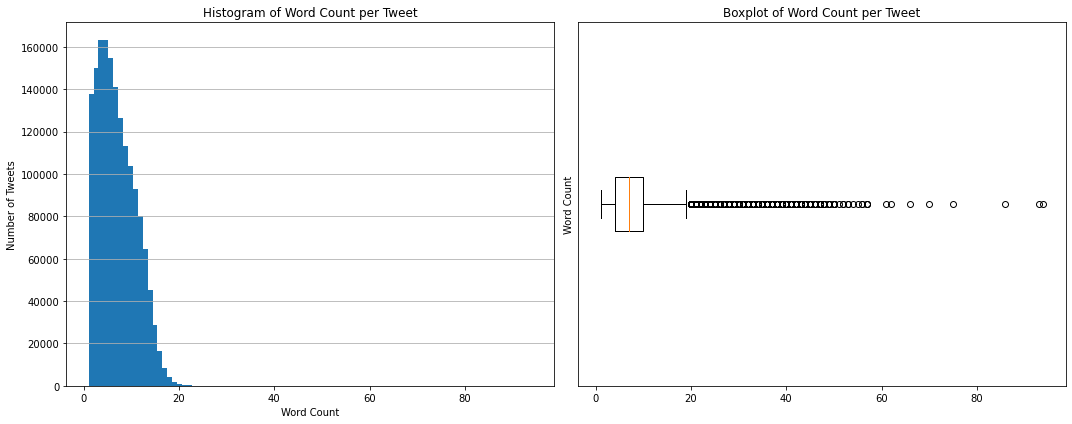

In [19]:
# Calculate the number of words in each tweet and store it in a new column 'num_words'
tweets['num_words'] = tweets['text6'].apply(lambda x: len(x.split(' ')))

# Generate descriptive statistics and add 90th and 95th percentiles
describe = pd.DataFrame(tweets['num_words'].describe()).T
percentile_90 = tweets['num_words'].quantile(0.90)
describe['90%'] = percentile_90
percentile_95 = tweets['num_words'].quantile(0.95)
describe['95%'] = percentile_95
describe = describe[[col for col in describe if col != "max"] + ["max"]]
display(describe)

# Create subplots for histogram and boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of word count per tweet on the first axis (ax1)
ax1.hist(tweets['num_words'], bins=90)
ax1.set_title('Histogram of Word Count per Tweet')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Number of Tweets')
ax1.grid(axis='y')

# Boxplot of word count per tweet on the second axis (ax2)
ax2.boxplot(tweets['num_words'], vert=False)
ax2.set_title('Boxplot of Word Count per Tweet')
ax2.set_ylabel('Word Count')
ax2.set_yticks([])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### Vectorization Upgrade: Capturing Linear Textual Nuances
At this stage of the project, the vectorization strategy was adjusted to preserve the order of words in sentences, a vital component for sentiment analysis. Instead of simply adding up the vectors of the words to create a single vector for each sentence (as initially done), now each word is represented individually up to a defined sequence limit (max_seq_length), forming a matrix of vectors for each sentence. This method, implemented by the vectorize_sequences function, aims to capture more complex semantic nuances present in the linear structure of the text.



In [20]:
# Function to vectorize sequences in batches and save them to disk
def vectorize_sequences(text, labels, modelo, batch_size=2560, max_seq_length=20, save_path="./"):
    # Initialize a WhitespaceTokenizer
    ws_tokenizer = WhitespaceTokenizer()

    # Calculate the number of batches needed
    num_batches = len(text) // batch_size + 1
    
    # Check if the existing number of batch files matches the number of new batches
    existing_files = len(os.listdir(save_path))
    if existing_files == num_batches:
        return False # No need to create new batches

    # Loop through each batch
    for batch_num in range(num_batches):
        # Define the start and end index for each batch
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(text))

        # Extract the texts and labels for the current batch
        batch_texts = text[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx].values  # Convert to numpy array

        # Initialize a list to store vectors for all texts in the batch
        all_vectors = []

        # Convert each text in the batch to vectors
        for txt in batch_texts:
            words = ws_tokenizer.tokenize(txt)
            vectors = [modelo.wv[word] for word in words if word in modelo.wv][:max_seq_length]
            all_vectors.append(vectors)

        # Initialize a zero-matrix to store the vectors
        matrix = np.zeros((len(all_vectors), max_seq_length, 300))
        
        # Fill the zero-matrix with the actual vectors
        for i, vectors in enumerate(all_vectors):
            for j, vector in enumerate(vectors):
                matrix[i][j] = vector

        # Combine the vectors and labels into a single dictionary
        batch_data = {'data': matrix, 'labels': batch_labels}
        
        # Save the batch to disk as a .npy file
        np.save(f"{save_path}batch_{batch_num}.npy", batch_data)
    return True

In [21]:
# Define the directory paths where the training and testing batches for CBOW and Skip-gram are stored
matrix_train_cbow = 'D:\\TSA_Batches\\cbow_train\\'
matrix_test_cbow = 'D:\\TSA_Batches\\cbow_test\\'
matrix_train_sg = 'D:\\TSA_Batches\\sg_train\\'
matrix_test_sg = 'D:\\TSA_Batches\\sg_test\\'

In [22]:
# List of directory paths where the vectorized data will be saved
path_lst = [matrix_train_cbow, matrix_test_cbow, matrix_train_sg, matrix_test_sg]

# Descriptive names for each folder in the path list
folder = ['CBow Training Data', 'CBow Test Data', 'SG Training Data', 'SG Test Data']

# Corresponding Word2Vec models for each type of data
model = [cbow,cbow,sg,sg]

# Loop through each directory path to vectorize and save the sequences
for i, path in enumerate(path_lst):
    # Record the time at the start of the vectorization process
    start_time = time.time()

    # Vectorize and save training data for CBOW and Skip-gram models
    if (folder[i]=='CBow Training Data' or folder[i]=='SG Training Data'):
        vectorized = vectorize_sequences(X_train, y_train, model[i], save_path=path_lst[i])

    # Vectorize and save test data for CBOW and Skip-gram models
    if (folder[i]=='CBow Test Data' or folder[i]=='SG Test Data'):
        vectorized = vectorize_sequences(X_test, y_test, model[i], save_path=path_lst[i])

     # Record the time at the end of the vectorization process
    end_time = time.time()

    # Print the time elapsed during the vectorization process
    if vectorized:
        print('{} Vectorized. Elapsed Time: {:.2f} seconds.'.format(folder[i], (end_time - start_time)))
    else:
        print("{} already vectorized. Skipping vectorization.".format(folder[i]))

CBow Training Data already vectorized. Skipping vectorization.
CBow Test Data already vectorized. Skipping vectorization.
SG Training Data already vectorized. Skipping vectorization.
SG Test Data already vectorized. Skipping vectorization.


### Adjustments to the LSTM Architecture

In [23]:
# Define custom Dataset class for handling batches of tweets
class TweetDataset(Dataset):
    def __init__(self, file_list):
        # Initialize the list of files to be loaded
        self.files = file_list

    def __len__(self):
        # Return the total number of files
        return len(self.files)

    def __getitem__(self, idx):
        # Load the data and labels from the .npy file at the given index
        data = np.load(self.files[idx], allow_pickle=True)
        
        # Extract 'data' and 'labels' from the loaded file
        # If 'data' or 'labels' is not found, default to zeros
        vectors = torch.tensor(data.item().get('data', np.zeros((1280, 20, 300))), dtype=torch.float32)
        labels = torch.tensor(data.item().get('labels', np.zeros(1280)), dtype=torch.float32)
        
        # Check that both vectors and labels are tensors
        assert isinstance(vectors, torch.Tensor), f"Data in {self.files[idx]} is not a tensor!"
        assert isinstance(labels, torch.Tensor), f"Labels in {self.files[idx]} is not a tensor!"
        
        return vectors, labels

In [24]:
# Define LSTM classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers=n_layers, 
                            batch_first=True, 
                            dropout=dropout_prob if n_layers > 1 else 0)

        # Fully connected layer for binary classification
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_prob)

    # Define forward pass
    def forward(self, x):
        # Forward pass through LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Extract the output of the last timestep for each sequence
        lstm_out = lstm_out[:, -1, :]
        
        # Apply dropout for regularization
        lstm_out = self.dropout(lstm_out)
        
        # Forward pass through the fully connected layer
        output = self.fc(lstm_out)
        
        return output

In [25]:
# Training function for a single epoch
def train(train_loader, net, epoch, criterion, optimizer):
    # Set the network to training mode
    net.train()

    # Initialize list to store batch losses
    epoch_loss = []

    # Iterate through each batch in the training data loader
    for batch in train_loader:
        dado, rotulo = batch
        
        # Remove the extra dimension and move tensors to the selected device (GPU/CPU)
        dado = dado.squeeze(0).to(device)
        rotulo = rotulo.squeeze(0).float().to(device)  # BCELoss expects float labels

        # Forward pass: compute predicted output and loss
        pred = net(dado)
        loss = criterion(pred, rotulo.unsqueeze(1))
        
        # Append the batch loss to the list of epoch losses
        epoch_loss.append(loss.cpu().data)

        # Backward pass: compute gradient and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Convert epoch loss to NumPy array and compute mean
    epoch_loss = np.asarray(epoch_loss)
    return epoch_loss.mean()

In [26]:
# Function to test the network
def test(test_loader, net, epoch, criterion):
    # Set the network to evaluation mode
    net.eval()

    # Initialize list to store batch losses
    epoch_loss = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Loop over each batch from the test set
        for batch in test_loader:
            dado, rotulo = batch
            
            # Remove the extra dimension and move tensors to the selected device (GPU/CPU)
            dado = dado.squeeze(0).to(device)
            rotulo = rotulo.squeeze(0).float().to(device)  # BCELoss expects float labels

            # Forward pass: compute predicted output and loss
            pred = net(dado)
            loss = criterion(pred, rotulo.unsqueeze(1))
            
            # Append the batch loss to the list of epoch losses
            epoch_loss.append(loss.cpu().data)

    # Convert epoch loss to NumPy array and compute mean
    epoch_loss = np.asarray(epoch_loss)
    return epoch_loss.mean()

In [27]:
def train_LSTM(matrix_train_path, matrix_test_path, args, hidden_size=32, input_size=300, output_size=1):

    # Start MLflow run for experiment tracking
    with mlflow.start_run(experiment_id=experiment_id):
        # Log hyperparameters
        for key, value in args.items():
            mlflow.log_param(key, value)

        # Log neural network architecture details
        mlflow.log_param('input_size', input_size)
        mlflow.log_param('hidden_size', hidden_size)
        mlflow.log_param('output_size', output_size)

        # Instantiate the model
        net = LSTMClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size, n_layers=2)
        net.to(device)

        # Sets the loss function
        criterion = nn.BCEWithLogitsLoss().to(device)

        # Chooses the optimizer based on user input
        if args['optimizer'] == 'SGD':
            optimizer = optim.SGD(net.parameters(), lr=args['lr'])
        if args['optimizer'] == 'Adam':
            optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

        # Initializes variables to keep track of losses and other metrics
        train_losses, test_losses = [], []
        best_test_loss = float('inf')
        best_model_epoch = -1
        no_improvement_epochs = 0
        epoch_durations = []

        # Records the time at which training starts
        start_time = time.time()

        # Main training loop
        for epoch in range(args['num_epochs']):
            epoch_start_time = time.time()

            # Update and display the training status
            clear_output(wait=True)
            print('Training neural network... Epoch ' + str(epoch) + '/' + str(args['num_epochs']-1))
            if len(epoch_durations) > 0:
                # Calculates and displays the mean epoch duration and estimated time to completion
                mean_time = np.mean(epoch_durations)
                estimative = ((args['num_epochs'] - epoch) * mean_time)
                print('Mean Epoch time duration: {:.2f} seconds | Estimated time to finish training: {:.2f} seconds.'.format(mean_time, estimative))
            
            if best_model_epoch!=-1:
                print("Best test loss epoch: " + str(best_model_epoch))

            
            # Load datasets and dataloaders
            def sort_key(s):
                return int(re.search(r'\d+', s).group())

            # Sorts and loads the training and test batch files
            train_file_list = [os.path.join(matrix_train_path, f) for f in os.listdir(matrix_train_path) if f.endswith('.npy')]
            train_file_list.sort(key=sort_key)
            
            test_file_list = [os.path.join(matrix_test_path, f) for f in os.listdir(matrix_test_path) if f.endswith('.npy')]
            test_file_list.sort(key=sort_key)

            # Creates DataLoader objects for training and test datasets
            train_dataset = TweetDataset(train_file_list)
            test_dataset = TweetDataset(test_file_list)
            
            train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=args['num_workers'])
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=args['num_workers'])

            # Trains the model for one epoch and logs the training loss
            epoch_train_loss = train(train_loader, net, epoch, criterion, optimizer)
            train_losses.append(epoch_train_loss)
            mlflow.log_metric("epoch_train_loss", epoch_train_loss, step=epoch)

            # Tests the model and logs the test loss
            epoch_test_loss = test(test_loader, net, epoch, criterion)
            test_losses.append(epoch_test_loss)
            mlflow.log_metric("epoch_test_loss", epoch_test_loss, step=epoch)

            # Checks for improvements in test loss for early stopping and model checkpointing
            dif = best_test_loss - epoch_test_loss
            
            # Early stopping and model checkpoint logic
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                # Save the state of the best model for future reference
                torch.save(net.state_dict(), 'backup_best_model.pth')
                mlflow.log_metric("best_test_loss_so_far", best_test_loss, step=epoch)
                best_model_epoch = epoch
            
            if dif > args['tolerance']:
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= args['patience']:
                    print("Early stopping at epoch: ", epoch)
                    break

            # Records the duration of each epoch for performance analysis
            epoch_end_time = time.time()
            epoch_durations.append(epoch_end_time - epoch_start_time)

        # Logs the overall time taken for the training process
        end_time = time.time()
        duration = end_time - start_time

        # Clears the output and prints the final training status
        clear_output(wait=True)
        print("Neural network training has finished. Elapsed Time: {:.2f} seconds.".format(duration))
        print("Best model saved.")
        print("Best test loss epoch: " + str(best_model_epoch))
        
        # Loads the best model for final evaluation
        net.load_state_dict(torch.load("backup_best_model.pth"))

        # Initialize lists for true and predicted test labels
        true_test_labels, predicted_test_labels = [], []

        # Evaluates the best model on the test set
        with torch.no_grad():
            for data,labels in test_loader:
                #print("Labels shape:", labels.shape)
                inputs = data.squeeze(0).to(device)
                outputs = net(inputs)
                predicted_labels = (outputs.squeeze() > 0.5).long()
                true_test_labels.extend(labels.squeeze(0).cpu().numpy())
                predicted_test_labels.extend(predicted_labels.cpu().numpy())
                #print(len(true_test_labels), len(predicted_test_labels))

        # Calculates performance metrics for the best model
        test_accuracy = accuracy_score(true_test_labels, predicted_test_labels)
        test_precision = precision_score(true_test_labels, predicted_test_labels)
        test_recall = recall_score(true_test_labels, predicted_test_labels)
        test_f1 = f1_score(true_test_labels, predicted_test_labels)

        # Logs the performance metrics using MLflow
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("duration", sum(epoch_durations))

        # Prints the performance metrics of the best model
        print("Best model metrics:")
        print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
            test_accuracy, test_precision, test_recall, test_f1))
    
    return (train_losses, test_losses, best_model_epoch)

### Setting Up MLflow Experiment Tracking

In [28]:
# Set experiment name for MLflow tracking
experiment_name = "LSTM"

# Check if experiment exists; create it if not
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    # Get existing experiment ID
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

set_seed(5)

### Parameter Grid Definition and Model Training

In [29]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorization': ['cbow', 'sg'], 
    'criterion': ['BCEWithLogitsLoss'], 
    'optimizer': ['Adam'], 
    'batch_size': [128],
    'num_workers': [0],
    'lr': [0.0001, 0.0005, 0.001], 
    'weight_decay': [0.0005, 0.0001, 0.001], 
    'num_epochs': [500],
    'tolerance': [0.0003],
    'patience': [10]
}

# Generate all combinations of hyperparameters for grid search
all_combinations = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]

# Remove already trained combinations from the list
not_trained_lst = remove_trained(all_combinations,experiment_id)

# Check if any combinations are left to train
if len(not_trained_lst)>0:
    print('There are {} combinations left to train.'.format(len(not_trained_lst)))
else:
    print('All models have already been trained.')

All models have already been trained.


In [30]:
# Initialize an empty list to store the results
results = []

# Record the start time for the training process
start_time = time.time()

# Loop through each combination of hyperparameters that have not yet been trained
for params in not_trained_lst:

    # Select the appropriate word vector based on the 'vectorization' parameter and train the neural network with the given parameters
    if params.get('vectorization') == 'cbow':
        train_losses, test_losses, best_epoch = train_LSTM(matrix_train_cbow, matrix_test_cbow, params, hidden_size=params.get('hidden_size', 256), input_size=params.get('input_size', 300), output_size=params.get('output_size', 1))

    else:
        train_losses, test_losses, best_epoch = train_LSTM(matrix_train_sg, matrix_test_sg, params, hidden_size=params.get('hidden_size', 256), input_size=params.get('input_size', 300), output_size=params.get('output_size', 1))

    # Append the training results to the results list
    results.append({
        'params': params,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'best_epoch': best_epoch
    })

# Record the end time and calculate the total duration
end_time = time.time()
duration = end_time - start_time
clear_output()

# Display the status of the training process
if len(not_trained_lst)>0:
    print('Training Process Finished. Elapsed Time: {:.2f} seconds.'.format(duration))
else:
    print('Training is already complete for all models.')

Training is already complete for all models.


### MLflow Experiment Retrieval and Data Preview

In [31]:
# Retrieve and display the experiment data, sorted by 'Best Loss'
df_lstm = retrieve_experiments(experiment_id)
display(df_lstm.sort_values(by='Best Loss', ascending=True))

,Run ID,Best Loss,Accuracy,F1,Recall,Precision,Duration,Vectorization,LR,Tolerance,Patience,Weight Decay
14,d72f8f3fcad84255838c99a880f7e0ec,0.436744,0.783693,0.763780,0.699000,0.841794,23631.324723,cbow,0.0005,0.0003,10,0.0001
13,148c1ba149bf4e90b7a5daae3de36ebd,0.437911,0.781558,0.760427,0.692963,0.842445,17468.263312,cbow,0.001,0.0003,10,0.0001
16,3e4e75ef579848c786f8af2c19b64863,0.440402,0.782910,0.765658,0.708890,0.832310,23987.815740,cbow,0.0001,0.0003,10,0.0001
11,bd81602a60334fdba038b34f1ee80bfa,0.441892,0.782641,0.765063,0.707420,0.832933,33972.275484,sg,0.0005,0.0003,10,0.0001
10,99ca3c62e73e4d99905353a7cc2a96eb,0.442978,0.778820,0.757903,0.692031,0.837636,36729.734913,sg,0.001,0.0003,10,0.0001
17,9e208bed79b343779265421c45cc615b,0.443190,0.781608,0.763868,0.706081,0.831957,51131.960991,cbow,0.0001,0.0003,10,0.0005
12,f82d81b9f18048b8b4de1e345d0db4b3,0.446117,0.779186,0.760530,0.700883,0.831273,42153.247715,sg,0.0001,0.0003,10,0.0001
15,74d9ff0b7cf04abcb3083f10617720f2,0.446320,0.777108,0.755791,0.689428,0.836290,24804.346572,cbow,0.0005,0.0003,10,0.0005
9,294387351fac4b08b109a04c643e084d,0.693146,0.499717,0.000000,0.000000,0.000000,9197.926338,cbow,0.0001,0.0003,10,0.001
3,029d485eab38455a9881e60063d8316a,0.693147,0.499717,0.000000,0.000000,0.000000,12124.521789,sg,0.0005,0.0003,10,0.0005


## Third Experiment: GRU Model

In the third experiment, the architecture transitions to Gated Recurrent Units (GRU), a variant of LSTM networks. GRUs offer a simpler computational model while retaining the ability to capture long-term dependencies in sequence data. The experiment seeks to determine whether GRU-based models can offer a balance between complexity and performance in sentiment analysis tasks.

### Adjustments to the GRU Architecture

In [32]:
# Define the GRU-based classifier model
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers, dropout_prob=0.5):
        super(GRUClassifier, self).__init__()
        
        # Initialize the GRU layer with the given dimensions and dropout rate.
        # If there's more than one layer, apply dropout; otherwise, don't.
        self.gru = nn.GRU(input_size, 
                       hidden_size, 
                       num_layers=n_layers, 
                       batch_first=True, 
                       dropout=dropout_prob if n_layers > 1 else 0)
        
        # Initialize the fully connected (linear) layer for classification
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Initialize the dropout layer with the given dropout rate
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Forward pass through the GRU layer
        # h_n is the hidden state for the last time step across all layers
        gru_out, h_n = self.gru(x)
        
        # Take the GRU output from the last time step for all samples in the batch
        gru_out = gru_out[:, -1, :]

        # Apply dropout to the GRU output to prevent overfitting
        gru_out = self.dropout(gru_out)
        
        # Forward pass through the fully connected layer to get the final output
        output = self.fc(gru_out)
        
        return output

In [33]:
def train_GRU(matrix_train_path, matrix_test_path, args, hidden_size=32, input_size=300, output_size=1):

    # Start MLflow run for experiment tracking
    with mlflow.start_run(experiment_id=experiment_id):
        # Log hyperparameters
        for key, value in args.items():
            mlflow.log_param(key, value)

        # Log neural network architecture details
        mlflow.log_param('input_size', input_size)
        mlflow.log_param('hidden_size', hidden_size)
        mlflow.log_param('output_size', output_size)

        # Instantiate the model
        net = GRUClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size, n_layers=2)
        net.to(device)
        
        # Sets the loss function
        criterion = nn.BCEWithLogitsLoss().to(device)

        # Chooses the optimizer based on user input
        if args['optimizer'] == 'SGD':
            optimizer = optim.SGD(net.parameters(), lr=args['lr'])
        
        if args['optimizer'] == 'Adam':
            optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

        # Initializes variables to keep track of losses and other metrics
        train_losses, test_losses = [], []
        best_test_loss = float('inf')
        best_model_epoch = -1
        no_improvement_epochs = 0
        epoch_durations = []

        # Records the time at which training starts
        start_time = time.time()

        # Main training loop
        for epoch in range(args['num_epochs']):
            epoch_start_time = time.time()

            # Update and display the training status
            clear_output(wait=True)
            print('Training neural network... Epoch ' + str(epoch) + '/' + str(args['num_epochs']-1))

            if len(epoch_durations) > 0:
                # Calculates and displays the mean epoch duration and estimated time to completion
                mean_time = np.mean(epoch_durations)
                estimative = ((args['num_epochs'] - epoch) * mean_time)
                print('Mean Epoch time duration: {:.2f} seconds | Estimated time to finish training: {:.2f} seconds.'.format(mean_time, estimative))
            
            if best_model_epoch!=-1:
                print("Best test loss epoch: " + str(best_model_epoch))

            # Load datasets and dataloaders
            def sort_key(s):
                return int(re.search(r'\d+', s).group())

            # Sorts and loads the training and test batch files
            train_file_list = [os.path.join(matrix_train_path, f) for f in os.listdir(matrix_train_path) if f.endswith('.npy')]
            train_file_list.sort(key=sort_key)
            
            test_file_list = [os.path.join(matrix_test_path, f) for f in os.listdir(matrix_test_path) if f.endswith('.npy')]
            test_file_list.sort(key=sort_key)

            # Creates DataLoader objects for training and test datasets
            train_dataset = TweetDataset(train_file_list)
            test_dataset = TweetDataset(test_file_list)
            
            train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=args['num_workers'])
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=args['num_workers'])

            # Trains the model for one epoch and logs the training loss
            epoch_train_loss = train(train_loader, net, epoch, criterion, optimizer)
            train_losses.append(epoch_train_loss)
            mlflow.log_metric("epoch_train_loss", epoch_train_loss, step=epoch)

            # Tests the model and logs the test loss
            epoch_test_loss = test(test_loader, net, epoch, criterion)
            test_losses.append(epoch_test_loss)
            mlflow.log_metric("epoch_test_loss", epoch_test_loss, step=epoch)

            # Checks for improvements in test loss for early stopping and model checkpointing
            dif = best_test_loss - epoch_test_loss
            
            # Early stopping and model checkpoint logic
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                # Save the state of the best model for future reference
                torch.save(net.state_dict(), 'backup_best_model.pth')
                mlflow.log_metric("best_test_loss_so_far", best_test_loss, step=epoch)
                best_model_epoch = epoch
                #no_improvement_epochs = 0
            
            if dif > args['tolerance']:
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1
                if no_improvement_epochs >= args['patience']:
                    print("Early stopping at epoch: ", epoch)
                    break

            # Records the duration of each epoch for performance analysis
            epoch_end_time = time.time()
            epoch_durations.append(epoch_end_time - epoch_start_time)

        # Logs the overall time taken for the training process
        end_time = time.time()
        duration = end_time - start_time

        # Clears the output and prints the final training status
        clear_output(wait=True)
        print("Neural network training has finished. Elapsed Time: {:.2f} seconds.".format(duration))
        print("Best model saved.")
        print("Best test loss epoch: " + str(best_model_epoch))
        
        # Loads the best model for final evaluation
        net.load_state_dict(torch.load("backup_best_model.pth"))

        # Initialize lists for true and predicted test labels
        true_test_labels, predicted_test_labels = [], []

        # Evaluates the best model on the test set
        with torch.no_grad():
            for data,labels in test_loader:
                inputs = data.squeeze(0).to(device)
                outputs = net(inputs)
                predicted_labels = (outputs.squeeze() > 0.5).long()
                true_test_labels.extend(labels.squeeze(0).cpu().numpy())
                predicted_test_labels.extend(predicted_labels.cpu().numpy())

        # Calculates performance metrics for the best model
        test_accuracy = accuracy_score(true_test_labels, predicted_test_labels)
        test_precision = precision_score(true_test_labels, predicted_test_labels)
        test_recall = recall_score(true_test_labels, predicted_test_labels)
        test_f1 = f1_score(true_test_labels, predicted_test_labels)

        # Logs the performance metrics using MLflow
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("duration", sum(epoch_durations))

        # Prints the performance metrics of the best model
        print("Best model metrics:")
        print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
            test_accuracy, test_precision, test_recall, test_f1))
    
    return (train_losses, test_losses, best_model_epoch)

### Parameter Grid Definition and Model Training

In [34]:
# Set experiment name for MLflow tracking
experiment_name = "GRU"

# Check if experiment exists; create it if not
if mlflow.get_experiment_by_name(experiment_name) is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    # Get existing experiment ID
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

set_seed(42)

In [35]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorization': ['cbow', 'sg'], 
    'criterion': ['BCEWithLogitsLoss'], 
    'optimizer': ['Adam'], 
    'batch_size': [128],
    'num_workers': [0],
    'lr': [0.0001, 0.0005, 0.001], 
    'weight_decay': [0.0005, 0.0001, 0.001], 
    'num_epochs': [500],
    'tolerance': [0.0003],
    'patience': [10]
}
# Generate all combinations of hyperparameters for grid search
all_combinations = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]

# Remove already trained combinations from the list
not_trained_lst = remove_trained(all_combinations,experiment_id)

# Check if any combinations are left to train
if len(not_trained_lst)>0:
    print('There are {} combinations left to train.'.format(len(not_trained_lst)))
else:
    print('All models have already been trained.')

All models have already been trained.


In [36]:
# Initialize an empty list to store the results
results = []

# Record the start time for the training process
start_time = time.time()

# Loop through each combination of hyperparameters that have not yet been trained
for params in not_trained_lst:

    # Select the appropriate word vector based on the 'vectorization' parameter and train the neural network with the given parameters
    if params.get('vectorization') == 'cbow':
        train_losses, test_losses, best_epoch = train_GRU(matrix_train_cbow, matrix_test_cbow, params, hidden_size=params.get('hidden_size', 256), input_size=params.get('input_size', 300), output_size=params.get('output_size', 1))

    else:
        train_losses, test_losses, best_epoch = train_GRU(matrix_train_sg, matrix_test_sg, params, hidden_size=params.get('hidden_size', 256), input_size=params.get('input_size', 300), output_size=params.get('output_size', 1))

    # Append the training results to the results list
    results.append({
        'params': params,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'best_epoch': best_epoch
    })

# Record the end time and calculate the total duration
end_time = time.time()
duration = end_time - start_time
clear_output()

# Display the status of the training process
if len(not_trained_lst)>0:
    print('Training Process Finished. Elapsed Time: {:.2f} seconds.'.format(duration))
else:
    print('Training is already complete for all models.')

Training is already complete for all models.


### MLflow Experiment Retrieval and Data Preview

In [37]:
# Retrieve and display the experiment data, sorted by 'Best Loss'
df_gru = retrieve_experiments(experiment_id)
display(df_gru.sort_values(by='Best Loss', ascending=True))

,Run ID,Best Loss,Accuracy,F1,Recall,Precision,Duration,Vectorization,LR,Tolerance,Patience,Weight Decay
13,fb56b00a4f0f4ae6b001d5ee3d155996,0.436536,0.783580,0.764470,0.702046,0.839078,24209.433861,cbow,0.0005,0.0003,10,0.0001
10,c4b9b3fe550c4915830022b0f3ab420b,0.437911,0.781830,0.761596,0.696560,0.840027,38000.263731,cbow,0.001,0.0003,10,0.0001
5,241f99a2db554eabbdd3c33113703c1d,0.440918,0.779449,0.757090,0.687013,0.843086,62607.626496,sg,0.0005,0.0003,10,0.0001
3,c14b798e3bf84d52a4a0b4675262a60e,0.441350,0.779292,0.757376,0.688571,0.841457,45175.305805,sg,0.001,0.0003,10,0.0001
16,a9e10d5053534ff3a6b92d2e6687ffb2,0.441539,0.785389,0.770823,0.721421,0.827487,23293.767386,cbow,0.0001,0.0003,10,0.0001
17,a3708d02bf084a5bbfb86ee13276de12,0.445336,0.775380,0.751504,0.678912,0.841478,43740.106391,cbow,0.0001,0.0003,10,0.0005
11,29b3830f4cae4c2e9af06bac30a331d3,0.446994,0.773665,0.748640,0.673726,0.842299,29875.553173,cbow,0.001,0.0003,10,0.0005
14,38535ed12a7e424bb06477a2431321ac,0.447434,0.778738,0.759951,0.700076,0.831025,19664.968760,cbow,0.0005,0.0003,10,0.0005
7,786a0d143a004400a4ec54f53c1b871f,0.448812,0.779252,0.761647,0.704993,0.828202,55645.610807,sg,0.0001,0.0003,10,0.0001
15,acb2c6a733b245e2bfb85d955adf3183,0.450839,0.774410,0.752599,0.685862,0.833724,37707.681145,cbow,0.0001,0.0003,10,0.001


## Statistical Analysis and Model Selection Insights

This section provides a rigorous statistical analysis aimed at validating the observed performance differences among the Basic, GRU, and LSTM model architectures. Various tests were conducted to assess not only the 'Best Loss' performance metrics but also the computational efficiency in terms of training time. The Shapiro-Wilk test confirmed that the 'Best Loss' data for each architecture approximately follow a normal distribution, thereby justifying the use of parametric tests for those metrics. However, due to the non-normal distribution of training times, non-parametric tests were employed to evaluate those differences.

Statistical tests like ANOVA and the t-test revealed significant differences in 'Best Loss' between the architectures, while the Kruskal-Wallis and Mann-Whitney tests were used to understand the differences in training time.


### Distribution Analysis of Model Performances by Architecture

In [38]:
# Add an 'Architecture' column to each DataFrame to categorize the type of neural network used
df_basic['Architecture'] = 'Basic'
df_lstm['Architecture'] = 'LSTM'
df_gru['Architecture'] = 'GRU'

# Sort the DataFrames based on the 'Best Loss' column in ascending order
# This helps to identify the best models in each category
basic_models = df_basic.sort_values(by='Best Loss', ascending=True)
lstm_models = df_lstm.sort_values(by='Best Loss', ascending=True)
gru_models = df_gru.sort_values(by='Best Loss', ascending=True)

# Concatenate the sorted DataFrames to create a comprehensive DataFrame
# This DataFrame will contain models from all architectures, sorted by their performance
final_results = pd.concat([basic_models, lstm_models, gru_models], ignore_index=True)

,count,mean,std,min,25%,50%,75%,max
Architecture,,,,,,,,
Basic,18.0,0.473952,0.005961,0.466808,0.469098,0.472464,0.478738,0.484852
GRU,18.0,0.488611,0.094341,0.436536,0.442488,0.449825,0.456792,0.693147
LSTM,18.0,0.581501,0.128462,0.436744,0.443031,0.693147,0.693147,0.693147


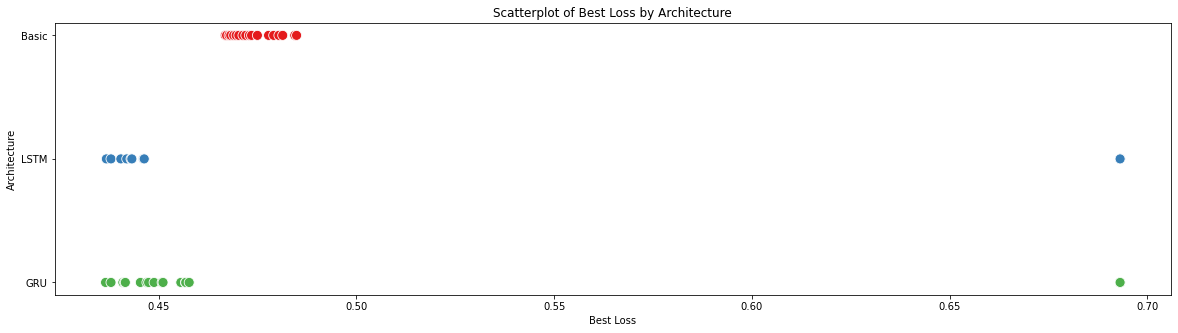

In [39]:
# Displays descriptive statistics of the 'Best Loss' column, grouped by 'Architecture'.
# This provides measures like mean, standard deviation, minimum, 25th percentile, etc., for each 'Architecture' group.
display(final_results.groupby('Architecture').describe()['Best Loss'])

# Generates a scatter plot that visualizes the 'Best Loss' for different neural network architectures.
# The x-axis represents the 'Best Loss' values, while the y-axis represents the different architectures.
# Each point on the plot is colored based on its architecture, and the size of each point is set to 100.
plt.figure(figsize=(20, 5))
sns.scatterplot(x='Best Loss', y='Architecture', hue='Architecture', data=final_results, palette='Set1', s=100, legend=False)
plt.title('Scatterplot of Best Loss by Architecture')
plt.xlabel('Best Loss')
plt.ylabel('Architecture')
plt.show()

In [40]:
# Filters the models with a 'Best Loss' greater than 0.5 and stores them in 'failed_models'.
# Then, it counts the number of failed models for each architecture and displays this information.
failed_models = final_results[final_results['Best Loss']>0.5]
failed_df = pd.DataFrame(failed_models['Architecture'].value_counts())
failed_df.columns = ['Number of Failed Models']
display(failed_df)

,Number of Failed Models
Architecture,
LSTM,10
GRU,3


The scatterplot above reveals a notable trend: several models from the LSTM and GRU architectures did not converge. This lack of convergence can be attributed to the complexity inherent to LSTM and GRU networks, making them more challenging to optimize. In contrast, the Basic architecture successfully converged in all instances.





### Performance Analysis of Converged Models

In this section, the focus shifts to a performance comparison among only the models that successfully converged. By narrowing down the selection, the analysis aims to offer a more accurate evaluation of each architecture's effectiveness.


,count,mean,std,min,25%,50%,75%,max
Architecture,,,,,,,,
Basic,18.0,0.473952,0.005961,0.466808,0.469098,0.472464,0.478738,0.484852
GRU,15.0,0.447704,0.007070,0.436536,0.441444,0.447434,0.453325,0.457688
LSTM,8.0,0.441944,0.003482,0.436744,0.439779,0.442435,0.443921,0.446320


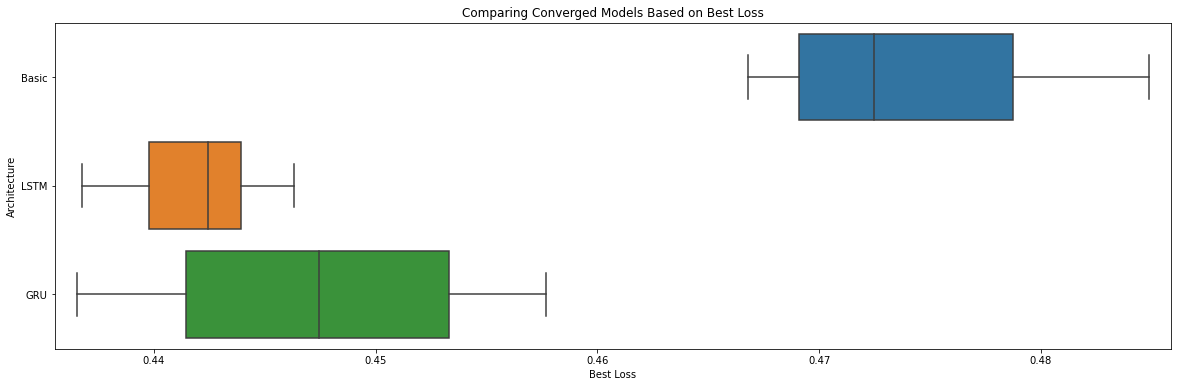

In [41]:
# Filters the models with a 'Best Loss' less than 0.5 and stores them in 'best_models'.
# Then, it displays descriptive statistics of 'Best Loss' for each architecture and visualizes this information using a horizontal boxplot.

best_models = final_results[final_results['Best Loss']<0.5]
display(best_models.groupby('Architecture').describe()['Best Loss'])

# Creates a horizontal boxplot to compare the 'Best Loss' among the different architectures for only the models with 'Best Loss' < 0.5.
plt.figure(figsize=(20, 6))
sns.boxplot(x="Best Loss", y="Architecture", data=best_models, orient='h')
plt.title("Comparing Converged Models Based on Best Loss")
plt.xlabel("Best Loss")
plt.ylabel("Architecture")

plt.xlim(best_models['Best Loss'].min()-0.001, best_models['Best Loss'].max()+0.001)
plt.show()

The statistical summary of the 'Best Loss' for converged models highlights different performance aspects across the Basic, GRU, and LSTM architectures. The Basic architecture exhibits a higher mean loss, but with less variability than GRU as indicated by a smaller standard deviation. Meanwhile, GRU models show a slightly higher variability but lower mean loss. The LSTM models stand out for not only having the lowest mean loss but also the least variability, suggesting both effective and consistent performance.

To rigorously assess the performance differences among the Basic, GRU, and LSTM architectures, a series of statistical tests were conducted. The aim of these tests is to determine whether the differences in mean loss across these architectures are statistically significant. This step is crucial for confirming whether the observed differences are genuine or could have occurred by chance.

Although the statistical tests provide valuable insights into the performance differences among the Basic, GRU, and LSTM architectures, it's important to note the limitations of this analysis. Specifically, the small sample size for the LSTM models—consisting of only 8 converged models—could affect the statistical power and reliability of the test results. Due to this limited sample size, the conclusions drawn about the LSTM architecture should be interpreted with caution.

#### Shapiro-Wilk Test

In [42]:
# Filters the 'Best Loss' data for each neural network architecture (GRU, LSTM, Basic) and performs the Shapiro-Wilk test to assess the normality of the data.
# The test results, including the W statistic and p-value, are printed for each architecture.

# Filter the 'Best Loss' data for each architecture
gru_data = best_models[best_models['Architecture'] == 'GRU']['Best Loss']
lstm_data = best_models[best_models['Architecture'] == 'LSTM']['Best Loss']
basic_data = best_models[best_models['Architecture'] == 'Basic']['Best Loss']

# Perform the Shapiro-Wilk test for normality on each filtered dataset
shapiro_test_gru = stats.shapiro(gru_data)
shapiro_test_lstm = stats.shapiro(lstm_data)
shapiro_test_basic = stats.shapiro(basic_data)

# Print the Shapiro-Wilk test results for each architecture
print('Shapiro Wilk:')
print(f"GRU: W = {shapiro_test_gru[0]}, p-value = {shapiro_test_gru[1]}")
print(f"LSTM: W = {shapiro_test_lstm[0]}, p-value = {shapiro_test_lstm[1]}")
print(f"Basic: W = {shapiro_test_basic[0]}, p-value = {shapiro_test_basic[1]}")

Shapiro Wilk:
GRU: W = 0.9374886751174927, p-value = 0.3518405854701996
LSTM: W = 0.9415451288223267, p-value = 0.6263448596000671
Basic: W = 0.9110510945320129, p-value = 0.08978526294231415


The Shapiro-Wilk test was conducted to assess the normality of the 'Best Loss' distributions for each architecture. 
In all cases, the 
p-values are greater than the common alpha level of 0.05, failing to reject the null hypothesis
. This suggests that the 'Best Loss' distributions for the GRU, LSTM, and Basic architectures do not significantly deviate from a normal distribution. 

#### Levene and Bartlett Tests

In [43]:
# Performs Levene and Bartlett tests to assess the homogeneity of variances across the 'Best Loss' data for each neural network architecture (GRU, LSTM, Basic).
# The test results, including the test statistics and p-values, are printed for both tests.

# Perform the Levene test for homogeneity of variances
levene_test_result = levene(gru_data, lstm_data, basic_data)

# Perform the Bartlett test for homogeneity of variances
bartlett_test_result = bartlett(gru_data, lstm_data, basic_data)

# Print the test results for Levene and Bartlett tests
print("Levene Test:")
print(f"Statistic: {levene_test_result.statistic}, p-value: {levene_test_result.pvalue}")

print("Bartlett Test:")
print(f"Statistic: {bartlett_test_result.statistic}, p-value: {bartlett_test_result.pvalue}")

Levene Test:
Statistic: 2.121231406128777, p-value: 0.13386065869571162
Bartlett Test:
Statistic: 3.665608500057695, p-value: 0.15996435816551732


Both the Levene and Bartlett tests were conducted to assess the homogeneity of variances across the 'Best Loss' distributions for the different architectures. In both tests, the p-values exceeded the common alpha level of 0.05, indicating a failure to reject the null hypothesis. This suggests that the variances of the 'Best Loss' for the Basic, GRU, and LSTM architectures are not significantly different.

#### ANOVA Test

In [44]:
# Filters the 'Best Loss' data for each neural network architecture (GRU, LSTM, Basic) and performs a one-way ANOVA test to compare the means.
# The test results, including the F-statistic and p-value, are printed.

# Filter the 'Best Loss' data for each architecture
gru_data = best_models[best_models['Architecture'] == 'GRU']['Best Loss']
lstm_data = best_models[best_models['Architecture'] == 'LSTM']['Best Loss']
basic_data = best_models[best_models['Architecture'] == 'Basic']['Best Loss']

# Perform the one-way ANOVA test to compare the means
f_stat, p_value = stats.f_oneway(gru_data, lstm_data, basic_data)

# Print the ANOVA test results
print('ANOVA:')
print("F-statistic:", f_stat)
print("P-value:", p_value)


ANOVA:
F-statistic: 112.63405491012612
P-value: 1.0673859551688611e-16


An ANOVA test was conducted to compare the 'Best Loss' across the Basic, GRU, and LSTM architectures. Given the extremely low 
p-value, far below the common alpha level of 0.05, the null hypothesis is rejected. This suggests that there are statistically significant differences in the 'Best Loss' means among the three architectures.

#### T-Test

In [45]:
# Filters the 'Best Loss' data for the GRU and LSTM neural network architectures and performs an independent two-sample t-test to compare their means.
# The test results, including the T-statistic and p-value, are printed.

# Filter the 'Best Loss' data for GRU and LSTM architectures
gru_data = best_models[best_models['Architecture'] == 'GRU']['Best Loss']
lstm_data = best_models[best_models['Architecture'] == 'LSTM']['Best Loss']

# Perform the independent two-sample t-test to compare the means
t_stat, p_value = stats.ttest_ind(gru_data, lstm_data)

# Print the T-test results
print('T-Test:')
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-Test:
T-statistic: 2.152087444425605
P-value: 0.043176145833083525


A t-test was conducted to evaluate the differences in 'Best Loss' between the GRU and LSTM architectures. Given that the 
p-value is less than the common alpha level of 0.05, the null hypothesis is rejected. This suggests that there is a statistically significant difference in 'Best Loss' between the GRU and LSTM architectures. 

### Training Time Analysis of Converged Models

,count,mean,std,min,25%,50%,75%,max
Architecture,,,,,,,,
Basic,18.0,1295.206998,380.136244,905.402970,1004.852687,1128.200542,1618.678929,2037.909769
GRU,15.0,44732.657092,26487.228280,17000.242563,27042.493517,38000.263731,50410.458306,121803.032488
LSTM,8.0,31734.871181,11288.406879,17468.263312,23898.692986,29388.311028,38085.613113,51131.960991


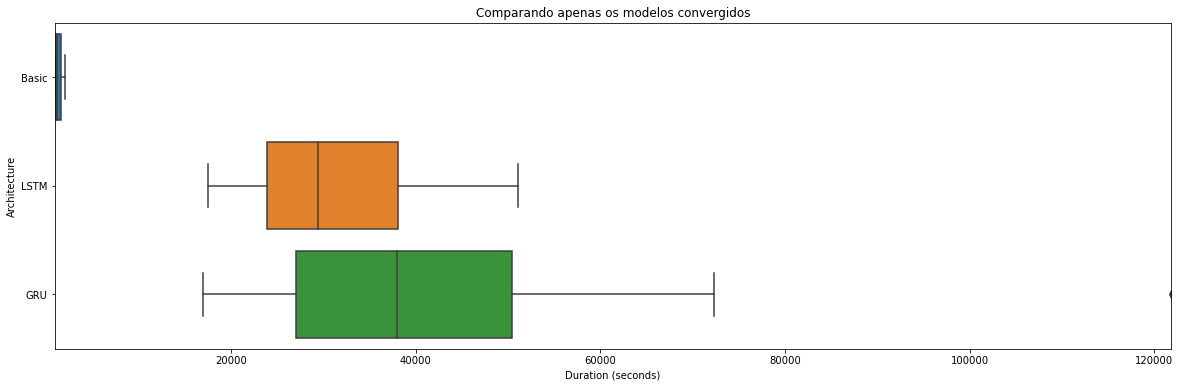

In [46]:
# Filters the models with a 'Best Loss' less than 0.5 and stores them in 'best_models'.
# Then, it displays descriptive statistics of 'Duration' for each architecture and visualizes this information using a horizontal boxplot.
# The x-axis limits are set to slightly beyond the minimum and maximum 'Duration' values for better visualization.

# Filter the models based on 'Best Loss' and display the descriptive statistics for 'Duration'
best_models = final_results[final_results['Best Loss']<0.5]
display(best_models.groupby('Architecture').describe()['Duration'])

# Initialize a new figure for the boxplot with dimensions 20x6.
# Create a horizontal boxplot to compare the 'Duration' among the different architectures for only the models with 'Best Loss' < 0.5.
plt.figure(figsize=(20, 6))
sns.boxplot(x="Duration", y="Architecture", data=best_models, orient='h')
plt.title("Comparando apenas os modelos convergidos")
plt.xlabel("Duration (seconds)")
plt.ylabel("Architecture")

# Set the x-axis limits to zoom in for better visualization
plt.xlim(best_models['Duration'].min()-0.001, best_models['Duration'].max()+0.001)
plt.show()

While GRU and LSTM architectures may offer better 'Best Loss' metrics, it is evident that they also require substantially more time to train. Specifically, the mean training time for GRU and LSTM models is approximately 44,733 seconds and 31,735 seconds, respectively, compared to just 1,295 seconds for the Basic architecture. This presents an important trade-off to consider, especially when working under time or computational resource constraints.

#### Shapiro-Wilk Test

In [47]:
# Filters the 'Duration' data for each neural network architecture (GRU, LSTM, Basic) and performs the Shapiro-Wilk test to assess the normality of the data.
# The test results, including the W statistic and p-value, are printed for each architecture.

# Filter the 'Duration' data for each architecture
gru_duration = best_models[best_models['Architecture'] == 'GRU']['Duration']
lstm_duration = best_models[best_models['Architecture'] == 'LSTM']['Duration']
basic_duration = best_models[best_models['Architecture'] == 'Basic']['Duration']

# Perform the Shapiro-Wilk test for normality on each filtered dataset
w_gru, p_gru = shapiro(gru_duration)
w_lstm, p_lstm = shapiro(lstm_duration)
w_basic, p_basic = shapiro(basic_duration)

# Print the Shapiro-Wilk test results for each architecture
print('Shapiro Wilk:')
print(f'GRU: W = {w_gru}, p-value = {p_gru}')
print(f'LSTM: W = {w_lstm}, p-value = {p_lstm}')
print(f'Basic: W = {w_basic}, p-value = {p_basic}')

Shapiro Wilk:
GRU: W = 0.8288368582725525, p-value = 0.008834054693579674
LSTM: W = 0.9412817358970642, p-value = 0.6237343549728394
Basic: W = 0.841869056224823, p-value = 0.006320524960756302


The Shapiro-Wilk test was performed to assess the normality of the training time distributions for each architecture. Given that not all groups follow a normal distribution, as indicated by the 
p-values below 0.05 for the GRU and Basic models, non-parametric statistical tests are more appropriate for comparing the group medians in subsequent analyses.

#### Kruskal-Wallis Test

In [48]:
# Filters the 'Duration' data for each neural network architecture (GRU, LSTM, Basic) and performs the Kruskal-Wallis test to compare their median values.
# The test results, including the H-statistic and p-value, are printed.

# Perform the Kruskal-Wallis test to compare the medians
h_stat, p_value = kruskal(gru_duration, lstm_duration, basic_duration)

# Print the Kruskal-Wallis test results
print('Kruskal-Wallis:')
print("H-statistic:", h_stat)
print("P-value:", p_value)

Kruskal-Wallis:
H-statistic: 30.05360046457608
P-value: 2.9781294993839873e-07


The Kruskal-Wallis test was conducted to compare the training time medians across the Basic, GRU, and LSTM architectures. Given the extremely low 
p-value, far below the common alpha level of 0.05, the null hypothesis is rejected. This suggests that there are statistically significant differences in the training time medians among the three architectures. It's worth noting that the Basic models had substantially shorter training times, which could be influencing the overall comparison. Therefore, a separate test was conducted to compare only the GRU and LSTM models, which had more similar training times.

#### Mann-Whitney Test

In [49]:
# Filters the 'Duration' data for the GRU and LSTM neural network architectures and performs a two-sided Mann-Whitney U test to compare their median values.
# The test results, including the U-statistic and p-value, are printed.

# Perform the two-sided Mann-Whitney U test to compare the medians between GRU and LSTM
u_stat, p_value = mannwhitneyu(gru_duration, lstm_duration, alternative='two-sided')

# Print the Mann-Whitney U test results
print('Mann-Whitney:')
print("U-statistic:", u_stat)
print("P-value:", p_value)

Mann-Whitney:
U-statistic: 79.0
P-value: 0.23820245801669948


A Mann-Whitney test was conducted to specifically compare the training time medians between the GRU and LSTM architectures. Given that the 
p-value is greater than the common alpha level of 0.05, the null hypothesis is not rejected. This suggests that there is no statistically significant difference in the training times between the GRU and LSTM architectures. In other words, based on the obtained data, it cannot be concluded that one architecture is faster or slower to train than the other.

## Conclusion

In summary, the comprehensive statistical analysis conducted on the 'Best Loss' and training times of the Basic, GRU, and LSTM architectures provided valuable insights into their performance and efficiency. While the LSTM architecture showed the most promising 'Best Loss' metrics, it was closely followed by the GRU architecture, both of which significantly outperformed the Basic model. However, this superior performance comes at the cost of increased training time, which is an essential factor to consider, particularly in scenarios with limited computational resources.

Statistical tests like ANOVA and the t-test corroborated these performance differences by revealing statistically significant variations in 'Best Loss' metrics among the architectures. Moreover, non-parametric tests like Kruskal-Wallis and Mann-Whitney were used due to the non-normal distribution of training times, showing significant differences among all three architectures, but not specifically between GRU and LSTM.